In [1]:
import pandas as pd
import numpy as np

from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense,RepeatVector, TimeDistributed, Dense, Dropout, LSTM
from tensorflow.python.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score


In [2]:
def conv_array(array):
    result=[]
    for r in array:
        result.append(r)
    return np.asarray(result)

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [3]:
data = pd.read_pickle("./DataSignal.pkl")
df_f40=data.loc[((data['Status'] == "OK")|(data['Status'] == "NOK"))&(data['Model'] == "F40")]

df_OK = df_f40.loc[(df_f40['Status']=="OK")]
df_NOK = df_f40.loc[(df_f40['Status']=="NOK")]

x_train = conv_array(df_OK['Vel'])
x_test = conv_array(df_NOK['Vel'])
y_train = np.asarray([1]*(len(df_OK['Status'])))
y_test = np.asarray([0]*(len(df_NOK['Status'])))



In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(2313, 3500)
(2313,)
(141, 3500)
(141,)


In [5]:
from sklearn.model_selection import train_test_split

pos = conv_array(df_f40['Pos'])


y = conv_array(df_f40['Status'])
lb = LabelEncoder()
y = lb.fit_transform(y)


X_t, X_te, y_t, y_te = train_test_split(pos, y, test_size=0.33, random_state=42)

In [6]:
nb_epoch = 50
batch_size = 10
input_dim =3500 #num of columns, 30
encoding_dim = 1000
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=90 
learning_rate = 1e-7

In [7]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3500)]            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              3501000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 90)                45090     
_________________________________________________________________
dense_3 (Dense)              (None, 500)               45500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0     

In [10]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mse',
                    optimizer='adam')

In [11]:
history = autoencoder.fit(x_train , x_train ,
                    epochs=30,
                    batch_size=batch_size,
                    validation_data=(X_t, X_t),
                    shuffle=True)

Epoch 1/30
232/232 [==============================] - 30s 68ms/step - loss: 0.0021 - accuracy: 0.0627 - val_loss: nan - val_accuracy: 6.0827e-04
Epoch 2/30
232/232 [==============================] - 16s 68ms/step - loss: 0.0020 - accuracy: 0.0519 - val_loss: nan - val_accuracy: 6.0827e-04
Epoch 3/30
232/232 [==============================] - 17s 72ms/step - loss: 0.0020 - accuracy: 0.0553 - val_loss: nan - val_accuracy: 6.0827e-04
Epoch 4/30
232/232 [==============================] - 16s 70ms/step - loss: 0.0021 - accuracy: 0.0636 - val_loss: nan - val_accuracy: 6.0827e-04
Epoch 5/30
232/232 [==============================] - 15s 67ms/step - loss: 0.0020 - accuracy: 0.0623 - val_loss: nan - val_accuracy: 6.0827e-04
Epoch 6/30
232/232 [==============================] - 18s 76ms/step - loss: 0.0028 - accuracy: 0.0653 - val_loss: nan - val_accuracy: 6.0827e-04
Epoch 7/30
232/232 [==============================] - 18s 78ms/step - loss: 0.0023 - accuracy: 0.0562 - val_loss: nan - val_accura

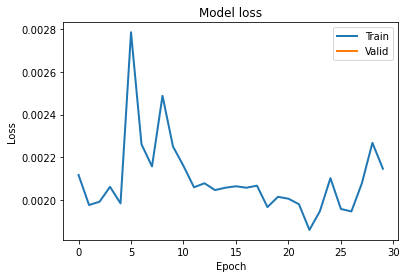

In [12]:
plt.plot(autoencoder.history.history['loss'], linewidth=2, label='Train')
plt.plot(autoencoder.history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

The loss funtion shows reptative behavior of input data

In [14]:
test_x_predictions = autoencoder.predict(X_t)
mse = np.mean(np.power(X_t - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_t})
error_df.loc[(error_df['True_class']==0)]

/home/admin/anaconda3/envs/tf-2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


,Reconstruction_error,True_class
6,326.288641,0
23,385.520368,0
25,431.415621,0
109,395.242326,0
141,1093.242774,0
...,...,...
1575,357.515299,0
1579,575.708800,0
1626,712.066274,0
1632,441.924117,0


# New Section

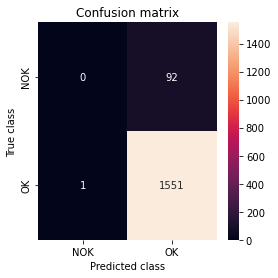

 Accuracy:  0.9434306569343066
 Recall:  0.9993556701030928
 Precision:  0.9440048691418138


In [15]:
threshold_fixed =0.0004

LABELS = ["NOK","OK"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

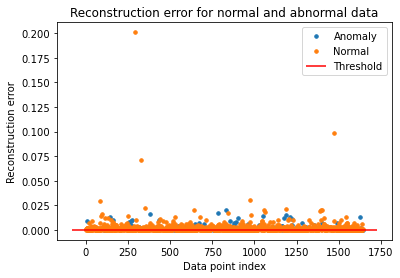

In [45]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Normal" if name == 1 else "Anomaly")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and abnormal data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();